# Contains the code that was exported from our package

In [8]:
import inspect
import platform
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from multiprocessing import cpu_count

from mlfinlab.corefns.core_functions import CoreFunctions

---
## Strategy Classes

In [9]:
class BaseStrategy(ABC):
    @abstractmethod
    def __init__(self, dir_name, asset_id, file_prefix):
        super().__init__()

        # Constants
        self.window = 50
        self.min_ret = 0.01
        self.pt_sl = [1, 1]

        self.dir_name = dir_name
        self.asset_id = asset_id
        self.file_prefix = file_prefix

        # core data sets
        self.close_prices = None
        self.daily_vol = None
        self.mean_daily_vol = None
        self.cusum_events = None
        self.vertical_barriers = None

        # strategy specific data sets
        self.events = None
        self.bins = None
        self.side = None

        # Run in single-threaded mode on Windows
        if platform.system() == "Windows":
            self.cpus = 1
        else:
            self.cpus = cpu_count() - 1

        # results data items ... These will be used to display
        self.fpr_rf = None
        self.tpr_rf = None
        self.y_test = None
        self.y_pred = None

    def initialize(self):
        """
        Follows on the design pattern that you don't want to have too much going on in the constructor and instead
        you may want to split it out into an initialize function.

        * Loads the data
        * Cleans the data by removing duplicates (I don't think that should happen!)
        * Computes the daily volatility
        * Apply Symmetric CUSUM filter to get timestamps at which to sample
        * Compute the vertical barriers
        """

        print('Entering {} ...'.format(inspect.stack()[0][3]))

        # Read dollar bars
        print("Read dollar bars from disk")
        file_name = self.dir_name + self.asset_id + '.parq'
        dbars = pd.read_parquet(file_name)

        # get close prices and remove duplicates (see ref below)
        # https://github.com/fernandodelacalle/adv-financial-ml-marcos-exercises/blob/master/notebooks/ch3.ipynb
        # cell 90

        # Todo: I don't like that it removes duplicates, feel as if the data is dirty or function for dollar bars wrong.
        # Extract and clean close prices
        print("Extract and clean close prices")
        close_prices = dbars.price.copy()
        close_prices = close_prices[~close_prices.index.duplicated(keep='first')]  # remove the duplicate index entries
        self.close_prices = close_prices  # save the close prices in the object

        # Compute daily volatility
        daily_vol = CoreFunctions.get_daily_vol(close_prices)
        mean_daily_vol = daily_vol.mean()
        self.daily_vol = daily_vol
        self.mean_daily_vol = mean_daily_vol

        # ToDo: This has to be adjusted to work on daily threshold changes based on volatility
        # Apply Symmetric CUSUM Filter and get timestamps for events
        t_events = CoreFunctions.get_t_events(close_prices, threshold=mean_daily_vol)
        self.cusum_events = t_events

        # Compute vertical barrier
        t1 = CoreFunctions.add_vertical_barrier(t_events, close_prices)
        self.vertical_barriers = t1

        print('Exiting {} ...'.format(inspect.stack()[0][3]))

    @abstractmethod
    def prep_strategy(self):
        pass

    def label(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        pt_sl = self.pt_sl
        target = self.daily_vol
        min_ret = self.min_ret
        cpus = self.cpus

        events = CoreFunctions.get_events(self.close_prices, self.cusum_events, pt_sl,
                                          target, min_ret, cpus, vertical_barrier_times=self.vertical_barriers)
        self.events = events

        # get bins
        print("Compute Bins")
        labels = CoreFunctions.get_bins(events, self.close_prices)
        # cprint(labels)

        print("Value counts of bins")
        print(labels.bin.value_counts())

        # Drop under-populated labels
        print("Drop labels that are under-populated")
        clean_labels = CoreFunctions.drop_labels(labels)
        # cprint(clean_labels)
        self.bins = clean_labels
        return None

    def present_results(self, name=''):
        if self.y_test is None:
            return
        print(classification_report(self.y_test, self.y_pred))

        plt.figure()
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr_rf, self.tpr_rf, label='RF')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve for ' + name)
        plt.legend(loc='best')

In [10]:
class MovingAvg(BaseStrategy):
    def __init__(self, dir_name, asset_id, file_prefix, slow_window=3, fast_window=7):
        super().__init__(dir_name, asset_id, file_prefix)

        # constants
        self.pt_sl = [1, 2]
        self.c_random_state = 777
        self.n_estimator = 10000

        self.slow_window = slow_window
        self.fast_window = fast_window

        # strategy specific data sets
        self.close_df = None
        self.side = None
        self.ma_side = None
        self.up = None
        self.down = None

    @staticmethod
    def get_up_cross(df):
        crit1 = df.fast.shift(1) < df.slow.shift(1)
        crit2 = df.fast > df.slow
        return df.fast[(crit1) & (crit2)]

    @staticmethod
    def get_down_cross(df):
        crit1 = df.fast.shift(1) > df.slow.shift(1)
        crit2 = df.fast < df.slow
        return df.fast[(crit1) & (crit2)]

    def prep_strategy(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        # Apply moving averages
        close_df = (pd.DataFrame()
                    .assign(price=self.close_prices)
                    .assign(fast=self.close_prices.ewm(self.fast_window).mean())
                    .assign(slow=self.close_prices.ewm(self.slow_window).mean()))

        # Compute up/down crosses
        up = MovingAvg.get_up_cross(close_df)
        down = MovingAvg.get_down_cross(close_df)

        # Derive meta-labels
        side_up = pd.Series(1, index=up.index)
        side_down = pd.Series(-1, index=down.index)
        self.side = pd.concat([side_up, side_down]).sort_index()
        self.close_df = close_df
        self.up = up
        self.down = down

        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return None

    def label(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))

        # compute MA events
        # Run in single-threaded mode on Windows
        cpus = self.cpus
        min_ret = self.min_ret
        pt_sl = self.pt_sl

        # Apply Triple Barrier and Meta Labeling
        ma_events = CoreFunctions.get_events(self.close_prices, self.cusum_events, pt_sl, self.daily_vol,
                                             min_ret, cpus,
                                             vertical_barrier_times=self.vertical_barriers,
                                             side=self.side)

        # compute bins
        print("Compute bins")
        ma_bins = CoreFunctions.get_bins(ma_events, self.close_prices).dropna()
        ma_side = ma_events.dropna().side

        self.ma_side = ma_side
        self.bins = ma_bins
        self.events = ma_events

        # Todo: Fix comments like this!
        # merge ... do i really need this merge?
        print("Merge ...")
        Xx = pd.merge_asof(ma_bins, ma_side.to_frame().rename(columns={0: 'side'}),
                           left_index=True, right_index=True, direction='forward')

        print('Exiting {} ...'.format(inspect.stack()[0][3]))

    def compute_size(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        # 3.4 (b) Train Random Forest to decide whether to train or not {0, 1) since the underlying model
        # (crossing m.a) has decided the side, {-1, 1}
        X = self.ma_side.values.reshape(-1, 1)
        y = self.bins.bin.values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=False)

        rf = RandomForestClassifier(max_depth=4, n_estimators=self.n_estimator,
                                    criterion='entropy', random_state=self.c_random_state)
        rf.fit(X_train, y_train)

        # The random forest model by itself
        y_pred_rf = rf.predict_proba(X_test)[:, 0]
        y_pred = rf.predict(X_test)
        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
        self.fpr_rf = fpr_rf
        self.tpr_rf = tpr_rf
        self.y_test = y_test
        self.y_pred = y_pred

        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return None

    def display_price_chart(self):
        f, ax = plt.subplots(figsize=(11, 8))

        self.close_df.loc['2014':].plot(ax=ax, alpha=.5)
        self.up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                                  alpha=0.75, label='upcross', color='g')
        self.down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7,
                                    alpha=0.75, label='downcross', color='r')

        plt.title('Moving Average')
        ax.legend()



In [11]:
class BollingerBand(BaseStrategy):
    def __init__(self, dir_name, asset_id, file_prefix, window=50):
        super().__init__(dir_name, asset_id, file_prefix)

        # constants
        self.pt_sl = [0, 2]
        self.c_random_state = 777
        self.n_estimator = 10000

        self.window = window

        # strategy specific data sets
        self.bb_df = None
        self.bb_side_raw = None
        self.bb_side = None
        self.bb_events = None
        self.bb_up = None
        self.bb_down = None

    @staticmethod
    def get_up_cross(df, col):
        # col is price column
        crit1 = df[col].shift(1) < df.upper.shift(1)
        crit2 = df[col] > df.upper
        return df[col][(crit1) & (crit2)]

    @staticmethod
    def get_down_cross(df, col):
        # col is price column
        crit1 = df[col].shift(1) > df.lower.shift(1)
        crit2 = df[col] < df.lower
        return df[col][(crit1) & (crit2)]

    @staticmethod
    def returns(s):
        arr = np.diff(np.log(s))
        return pd.Series(arr, index=s.index[1:])

    @staticmethod
    def df_rolling_autocorr(df, window, lag=1):
        """Compute rolling column-wise autocorrelation for a DataFrame."""
        return df.rolling(window=window).corr(df.shift(lag))  # could .dropna() here

    @staticmethod
    def bbands(price, window=None, width=None, numsd=None):
        """ returns average, upper band, and lower band"""
        ave = price.rolling(window).mean()
        sd = price.rolling(window).std(ddof=0)
        if width:
            upband = ave * (1 + width)
            dnband = ave * (1 - width)
            return price, np.round(ave, 3), np.round(upband, 3), np.round(dnband, 3)
        if numsd:
            upband = ave + (sd * numsd)
            dnband = ave - (sd * numsd)
            return price, np.round(ave, 3), np.round(upband, 3), np.round(dnband, 3)

    @staticmethod
    def df_bb_rolling_autocorr(df, window, lag=1):
        """Compute rolling column-wise autocorrelation for a DataFrame."""
        return df.rolling(window=window).corr(df.shift(lag))  # could .dropna() here

    def prep_strategy(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        bb_df = pd.DataFrame()
        bb_df['price'], bb_df['ave'], bb_df['upper'], bb_df['lower'] \
            = BollingerBand.bbands(self.close_prices, window=self.window, numsd=1)
        bb_df.dropna(inplace=True)
        # cprint(bb_df)

        # compute up & down signals
        bb_down = BollingerBand.get_down_cross(bb_df, 'price')
        bb_up = BollingerBand.get_up_cross(bb_df, 'price')

        print("Get meta-labels")
        bb_side_up = pd.Series(-1, index=bb_up.index)  # sell on up cross for mean reversion
        bb_side_down = pd.Series(1, index=bb_down.index)  # buy on down cross for mean reversion
        bb_side_raw = pd.concat([bb_side_up, bb_side_down]).sort_index()
        # cprint(bb_side_raw)

        self.bb_df = bb_df
        self.bb_up = bb_up
        self.bb_down = bb_down
        self.bb_side_raw = bb_side_raw
        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return None

    def label(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        cpus = self.cpus
        min_ret = self.min_ret
        pt_sl = self.pt_sl
        bb_events = CoreFunctions.get_events(self.close_prices, self.cusum_events,
                                             pt_sl, self.daily_vol, min_ret, cpus,
                                             vertical_barrier_times=self.vertical_barriers, side=self.bb_side_raw)
        # cprint(bb_events)

        bb_side = bb_events.dropna().side
        # cprint(bb_side)

        # print("Value Counts")
        # print(bb_side.value_counts())

        print("Compute bins")
        bb_bins = CoreFunctions.get_bins(bb_events, self.close_prices).dropna()
        # cprint(bb_bins)

        print("Bins Value Counts")
        print(bb_bins.bin.value_counts())

        self.events = bb_events
        self.side = bb_side
        self.bins = bb_bins
        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return None

    def get_ma_side(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        ma_strategy = MovingAvg(self.dir_name, self.asset_id, self.file_prefix)
        ma_strategy.close_prices = self.close_prices
        ma_strategy.daily_vol = self.daily_vol
        ma_strategy.mean_daily_vol = self.mean_daily_vol
        ma_strategy.cusum_events = self.cusum_events
        ma_strategy.vertical_barriers = self.vertical_barriers

        ma_strategy.prep_strategy()
        ma_strategy.label()
        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return ma_strategy.ma_side

    def compute_size(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))

        # compute ma_side
        ma_side = self.get_ma_side()

        print("Compute serial correlation")
        srl_corr = BollingerBand.df_bb_rolling_autocorr(
            BollingerBand.returns(self.close_prices), window=self.window).rename('srl_corr')
        # cprint(srl_corr)

        # compute features
        print("Compute features")
        features = (pd.DataFrame()
                    .assign(vol=self.events.trgt)
                    .assign(ma_side=ma_side)
                    .assign(srl_corr=srl_corr)
                    .drop_duplicates()
                    .dropna())

        print("Merge ...")
        Xy = (pd.merge_asof(features, self.bins[['bin']],
                            left_index=True, right_index=True,
                            direction='forward').dropna())
        # print(Xy.bin.value_counts())

        print("Train and test")
        X = Xy.drop('bin', axis=1).values
        y = Xy['bin'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

        rf = RandomForestClassifier(max_depth=2, n_estimators=self.n_estimator,
                                    criterion='entropy', random_state=self.c_random_state)
        rf.fit(X_train, y_train)

        # The random forest model by itself
        y_pred_rf = rf.predict_proba(X_test)[:, 1]
        y_pred = rf.predict(X_test)
        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
        self.fpr_rf = fpr_rf
        self.tpr_rf = tpr_rf
        self.y_test = y_test
        self.y_pred = y_pred
        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return

    def display_price_chart(self):
        f, ax = plt.subplots(figsize=(11, 8))

        self.bb_df.loc['2014':].plot(ax=ax, alpha=.5)
        self.bb_up.loc['2014':].plot(ax=ax, ls='', marker='^', markersize=7,
                                     alpha=0.75, label='upcross', color='g')
        self.bb_down.loc['2014':].plot(ax=ax, ls='', marker='v', markersize=7,
                                       alpha=0.75, label='downcross', color='r')

        plt.title('Bollinger Band')
        ax.legend()

In [12]:
class BollingerBandNoSecFilter(BaseStrategy):
    def __init__(self, dir_name, asset_id, file_prefix, window=50):
        super().__init__(dir_name, asset_id, file_prefix)

        self.bb_strategy = BollingerBand(dir_name, asset_id, file_prefix)
        self.bb_strategy.initialize()

    def label(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        pt_sl = self.bb_strategy.pt_sl
        target = self.bb_strategy.daily_vol
        min_ret = self.bb_strategy.min_ret
        cpus = self.bb_strategy.cpus

        events = CoreFunctions.get_events(self.bb_strategy.close_prices, self.bb_strategy.cusum_events, pt_sl,
                                          target, min_ret, cpus, vertical_barrier_times=self.bb_strategy.vertical_barriers)

        # get bins
        print("Compute Bins")
        labels = CoreFunctions.get_bins(events, self.close_prices)
        # cprint(labels)
        self.events = events
        self.bins = labels
        print('Exiting {} ...'.format(inspect.stack()[0][3]))

    def get_ma_side(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        ma_strategy = MovingAvg(self.dir_name, self.asset_id, self.file_prefix)
        ma_strategy.close_prices = self.bb_strategy.close_prices
        ma_strategy.daily_vol = self.bb_strategy.daily_vol
        ma_strategy.mean_daily_vol = self.bb_strategy.mean_daily_vol
        ma_strategy.cusum_events = self.bb_strategy.cusum_events
        ma_strategy.vertical_barriers = self.bb_strategy.vertical_barriers

        ma_strategy.prep_strategy()
        ma_strategy.label()
        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return ma_strategy.ma_side

    def compute_size(self):
        print('Entering {} ...'.format(inspect.stack()[0][3]))
        ma_side = self.get_ma_side()

        print("Compute serial correlation")
        srl_corr = BollingerBand.df_bb_rolling_autocorr(
            BollingerBand.returns(self.bb_strategy.close_prices), window=self.bb_strategy.window).rename('srl_corr')
        # cprint(srl_corr)

        features = (pd.DataFrame()
                    .assign(vol=self.events.trgt)
                    .assign(ma_side=ma_side)
                    .assign(srl_corr=srl_corr)
                    .drop_duplicates()
                    .dropna())

        Xy = (pd.merge_asof(features, self.bins[['bin']],
                            left_index=True, right_index=True,
                            direction='forward').dropna())
        # cprint(Xy)

        X = Xy.drop('bin', axis=1).values
        y = Xy['bin'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

        rf = RandomForestClassifier(max_depth=2, n_estimators=self.bb_strategy.n_estimator,
                                    criterion='entropy', random_state=self.bb_strategy.c_random_state)

        rf.fit(X_train, y_train)

        # The random forest model by itself
        y_pred_rf = rf.predict_proba(X_test)[:, 1]
        y_pred = rf.predict(X_test)
        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
        self.fpr_rf = fpr_rf
        self.tpr_rf = tpr_rf
        self.y_test = y_test
        self.y_pred = y_pred
        print('Exiting {} ...'.format(inspect.stack()[0][3]))
        return

--- 

## Run the various strategies

In [15]:
# Import data
dir_name = './mlfinlab/tests/data/processed/DOL_'
# file_prefix = 'WDC_tickbidask'
# asset_name = 'WDC'

file_prefix = 'IVE_tickbidask'
asset_name = 'IVE'

### Moving Average Crossover Strategy

Moving Average Crossover Strategy
Entering initialize ...
Read dollar bars from disk
Extract and clean close prices
Calculating daily volatility for dynamic thresholds


  1%|          | 593/56549 [00:00<00:09, 5924.17it/s]

Applying Symmetric CUSUM filter.


100%|██████████| 56549/56549 [00:07<00:00, 7127.34it/s]


Exiting initialize ...
Entering prep_strategy ...
Exiting prep_strategy ...
Entering label ...


/home/ariadne/Desktop/Research Project/research/chapter3/mlfinlab/corefns/core_functions.py:192: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
/home/ariadne/Desktop/Research Project/research/chapter3/mlfinlab/corefns/core_functions.py:206: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  side_ = side.loc[target.index]
2019-03-01 13:18:48.297759 100.0% apply_pt_sl_on_t1 done after 0.02 minutes. Remaining 0.0 minutes.


Compute bins
Merge ...
Exiting label ...
Entering compute_size ...
Exiting compute_size ...
              precision    recall  f1-score   support

           0       0.49      1.00      0.66        45
           1       0.00      0.00      0.00        46

   micro avg       0.49      0.49      0.49        91
   macro avg       0.25      0.50      0.33        91
weighted avg       0.24      0.49      0.33        91



/home/ariadne/anaconda3/envs/mlfinlab/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


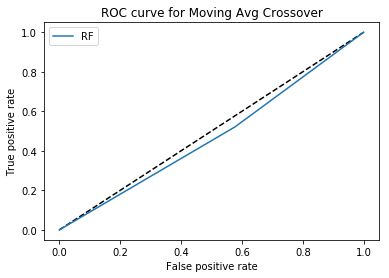

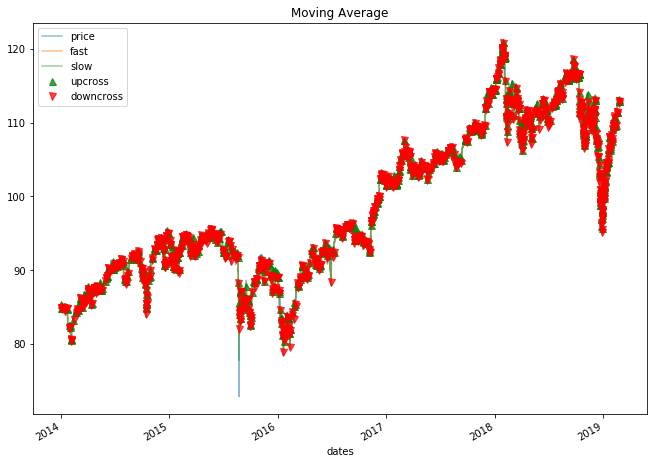

In [14]:
print("Moving Average Crossover Strategy")
strategy = MovingAvg(dir_name, asset_name, file_prefix)
strategy.initialize()
strategy.prep_strategy()
strategy.label()
strategy.compute_size()
strategy.present_results('Moving Avg Crossover')
strategy.display_price_chart()

plt.show()

In [ ]:
"""
print("Mean-reverting Bollinger Band Strategy")
strategy = BollingerBand(dir_name, asset_name, file_prefix)
strategy.initialize()
strategy.prep_strategy()
strategy.label()
strategy.compute_size()
strategy.present_results('Mean-reverting BBand')
strategy.display_price_chart()

print("Mean-reverting Bollinger Band Strategy when Sec Filter is dormant")
strategy = BollingerBandNoSecFilter(dir_name, asset_name, file_prefix)
strategy.initialize()
strategy.prep_strategy()
strategy.label()
strategy.compute_size()
strategy.present_results('M-R BBand When Sec Model is dormant')
"""